In [93]:
import pandas as pd
series = pd.read_csv('international-airline-passengers.csv', sep = ',', header = 0, index_col = 0, names = ['Month','No_Pas'])
series.head()

,No_Pas
Month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


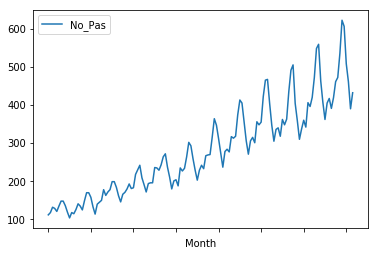

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline 
series.plot()

In [95]:
diff = series.diff().iloc[1:]
diff[:5]

,No_Pas
Month,
1949-02,6.0
1949-03,14.0
1949-04,-3.0
1949-05,-8.0
1949-06,14.0


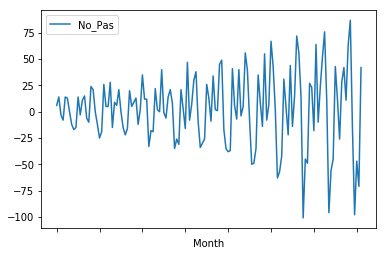

In [31]:
diff.plot()

In [46]:
X = [diff.shift(i).values for i in range(2)]
X = np.concatenate(X, axis = 1)
data = pd.DataFrame(X, columns = ['diff', 'lag_diff_1'])
data.fillna(0, inplace = True)
data = data.values
data[:5]

array([[ 6.,  0.],
       [14.,  6.],
       [-3., 14.],
       [-8., -3.],
       [14., -8.]])

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1, 1))
train, test = data[:-24, :], data[-24:, :]
scaler = scaler.fit(train)
train_scale = scaler.transform(train)
test_scale = scaler.transform(test)

In [58]:
X_train, y_train = train_scale[:, 1:], train_scale[:, 0]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print('X shape: {}'.format(X_train.shape))
print('y shape: {}'.format(y_train.shape))

X shape: (120, 1, 1)
y shape: (120,)


In [61]:
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

n_neurons = 4
batch_size = 1
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape = (batch_size, X_train.shape[1], X_train.shape[2]), stateful = True))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [62]:
n_pochs = 100
for i in range(n_pochs):
    model.fit(X_train, y_train, batch_size = batch_size, shuffle = False)
    model.reset_states()

Epoch 1/1
120/120 [==============================] - 2s 18ms/step - loss: 0.1205
Epoch 1/1
120/120 [==============================] - 1s 4ms/step - loss: 0.1113

In [63]:
model.predict(X_train, batch_size = 1)

array([[ 0.07141539],
       [ 0.15424252],
       [ 0.20052397],
       [ 0.16659996],
       [ 0.17124212],
       [ 0.23125437],
       [ 0.21588546],
       [ 0.1914911 ],
       [ 0.16759852],
       [ 0.15904707],
       [ 0.16426125],
       [ 0.24025965],
       [ 0.17551345],
       [ 0.23465806],
       [ 0.22640863],
       [ 0.17693084],
       [ 0.18030122],
       [ 0.26687995],
       [ 0.2331233 ],
       [ 0.19307801],
       [ 0.1723935 ],
       [ 0.1397528 ],
       [ 0.15993565],
       [ 0.27396888],
       [ 0.18733326],
       [ 0.21831155],
       [ 0.2670056 ],
       [ 0.14150733],
       [ 0.24372774],
       [ 0.20053816],
       [ 0.2568518 ],
       [ 0.1836114 ],
       [ 0.16797978],
       [ 0.14852056],
       [ 0.16615844],
       [ 0.2570406 ],
       [ 0.19276288],
       [ 0.22664815],
       [ 0.2254776 ],
       [ 0.1618987 ],
       [ 0.2168796 ],
       [ 0.28478763],
       [ 0.20612177],
       [ 0.23450938],
       [ 0.1044599 ],
       [ 0

In [96]:
predictions = list()
diff_pred = list()
for i in range(1, len(test_scale)):
    Xi, yi = test_scale[i, 1:], test_scale[i, 0]
    Xi = Xi.reshape(1, 1, 1)
    yhat = model.predict(Xi, batch_size = 1)
    pred_scale = np.concatenate([yhat, Xi[0]], axis = 1)
    yhat = scaler.inverse_transform(pred_scale)[0, 0]
    diff_pred.append(yhat)
    yhat = series.iloc[-(i+1), :] + yhat
    predictions.append(yhat)

([<matplotlib.axis.XTick at 0x215906a4ef0>,
 <a list of 23 Text xticklabel objects>)

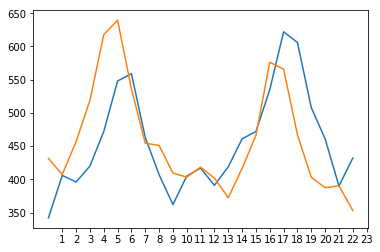

In [101]:
plt.plot(series.iloc[-24:,:])
plt.plot(predictions)
plt.xticks(np.arange(1, 24, 1), np.arange(1, 24, 1))

In [114]:
from math import sqrt
mse = sqrt(mean_squared_error(predictions, series[-24:-1]))
print('Mean squared error: %s'%mse)

Mean squared error: 68.185792428781
